## Import the Model

In [ ]:
import tensorflow as tf
# tf.enable_eager_execution()

from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
model = VGG19(
include_top = False, # dont need output layer
weights = 'imagenet'
)
model.trainable = False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

## Import Libraries and Helper Functions

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Image Processing and Display

In [ ]:
def load_and_process_img(img_path):
    img = load_img(img_path)
    img  = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0) # converting to  shape (m , r, g, b)
    return img

In [ ]:
def deprocess(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.799
    x[:, :, 2] += 123.68
    x= x[:,:, ::-1]
    x = np.clip(x, 0,255).astype('uint8')
    return x

def display_image(img):
    if len(img.shape) == 4:
        img = np.squeeze(img,  axis=0) # shape to 3d
    img  = deprocess(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.savefig('xyz.jpg')
    return

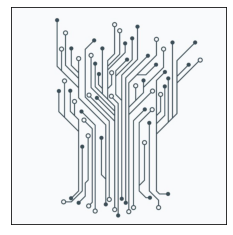

In [ ]:
display_image(load_and_process_img('style.jpg'))

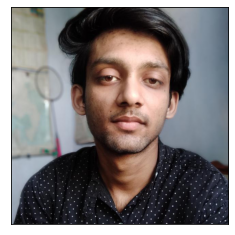

In [ ]:
display_image(load_and_process_img('content.jpg'))

## Content and Style Models

In [ ]:
content_layer  = 'block5_conv2' #deeper layers recognise more content

# using three layers for style cost so that more style is captured
# using shallower layeers as they capture more low level features 
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1',
] 

content_model = Model(
    inputs = model.input, 
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input, outputs = model.get_layer(layer).output) for layer in style_layers]

## Content Cost

In [ ]:
def content_cost(content, generated):
    a_c = content_model(content)
    a_g = content_model(generated)
    cost  = tf.reduce_mean(tf.square(a_c - a_g))
    return cost

## Gram Matrix

In [ ]:
def gram_matrix(A):
    n_c= int(A.shape[-1])
    a = tf.reshape(A, [-1, n_c])
    n = tf.shape(a)[0]
    g = tf.matmul(a, a, transpose_a = True)
    return g/tf.cast(n, tf.float32)

## Style Cost

In [ ]:
lam = 1. / len(style_models)
def style_cost(style, generated):
    j_style = 0
    for style_model in style_models:
        a_s = style_model(style)
        a_g = style_model(generated)
        gs = gram_matrix(a_s)
        gg = gram_matrix(a_g)
        current_cost = tf.reduce_mean(tf.square(gs-gg))
        j_style+= current_cost*lam
    return j_style

## Training Loop

In [ ]:
import time
generated_images = []

def training_loop(content_path, style_path, iterations = 60, alpha=10., beta = 15.):
    # alpha = content cost; beta=  style cosst weight
    content = load_and_process_img(content_path)
    style = load_and_process_img(style_path)
    generated  = tf.Variable(content, dtype = tf.float32)
    opt = tf.compat.v1.train.AdamOptimizer(learning_rate=7.)
    best_cost = 1e12 + .1
    best_image = None
    start = time.time()
    for i in range(iterations):
        with tf.GradientTape() as tape:
            j_content = content_cost(content, generated)
            j_style = style_cost(style, generated)
            j_total = alpha*j_content + beta*j_style
            
        grads = tape.gradient(j_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if j_total<best_cost:
            best_cost = j_total
            best_image = generated.numpy()
            
        print('cost at{}: {}. ta : {}'.format(i, j_total, time.time() - start))
        generated_images.append(generated.numpy())
    return best_image

 

In [ ]:
best_image = training_loop('content.jpg', 'style.jpg')


cost at0: 21396297728.0. ta : 4.995473861694336
cost at1: 20586887168.0. ta : 7.302362680435181
cost at2: 17495271424.0. ta : 9.607068061828613
cost at3: 14157312000.0. ta : 11.913758993148804
cost at4: 11944347648.0. ta : 14.21973204612732
cost at5: 10845400064.0. ta : 16.529232025146484
cost at6: 9912034304.0. ta : 18.831772804260254
cost at7: 9000323072.0. ta : 21.133984327316284
cost at8: 8240198144.0. ta : 23.444289684295654
cost at9: 7645760512.0. ta : 25.762428998947144
cost at10: 7154424832.0. ta : 28.06639814376831
cost at11: 6713546240.0. ta : 30.369697332382202
cost at12: 6302620672.0. ta : 32.6796510219574
cost at13: 5923771392.0. ta : 34.99708318710327
cost at14: 5578482176.0. ta : 37.31720972061157
cost at15: 5267347968.0. ta : 39.62841606140137
cost at16: 4983987200.0. ta : 41.94366264343262
cost at17: 4725485056.0. ta : 44.261287689208984
cost at18: 4488773120.0. ta : 46.5846803188324
cost at19: 4269291520.0. ta : 48.90780568122864
cost at20: 4066482432.0. ta : 51.24490

## Plot the Results

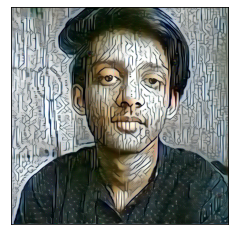

In [ ]:
bim = np.array(best_image)
display_image(bim)

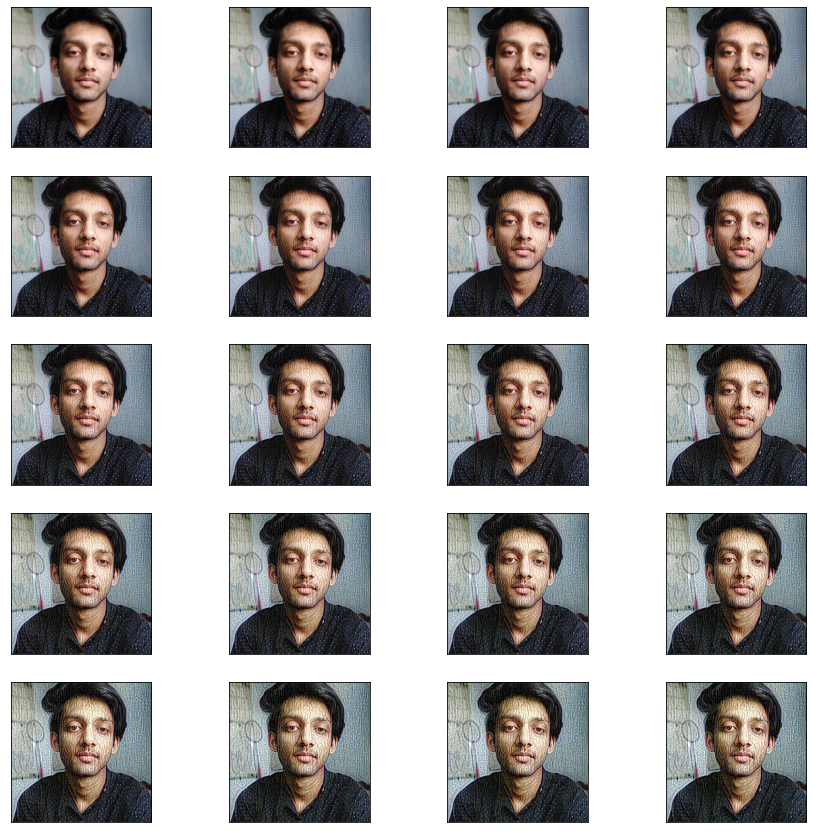

In [ ]:
plt.figure(figsize = (15,15))
for i in range(20):
    plt.subplot(5, 4, i+1)
    display_image(generated_images[i])
plt.show()

In [ ]:
!dir

 Volume in drive C is Acer
 Volume Serial Number is C41B-ECC0

 Directory of C:\Users\ACER\Desktop\Machine-Learning\Notebooks

16-06-2020  15:11    <DIR>          .
16-06-2020  15:11    <DIR>          ..
16-06-2020  15:00    <DIR>          .ipynb_checkpoints
12-02-2019  17:57            28,707 content.jpg
12-02-2019  17:57           414,810 example.png
12-02-2019  17:57           145,609 final.png
12-02-2019  17:57           406,956 intermediate.png
16-06-2020  15:00             7,981 nb.ipynb
16-06-2020  14:54         3,214,211 Notebooks.7z
16-06-2020  15:11         2,137,177 NST.ipynb
12-02-2019  18:12         1,055,753 NST_Complete.ipynb
12-02-2019  17:57            30,655 style.jpg
               9 File(s)      7,441,859 bytes
               3 Dir(s)  808,462,995,456 bytes free
